# Symptoms and Diagnosis


View this blog for detailed description :https://wp.me/pccXal-Bs


## The flow of the app looks like this

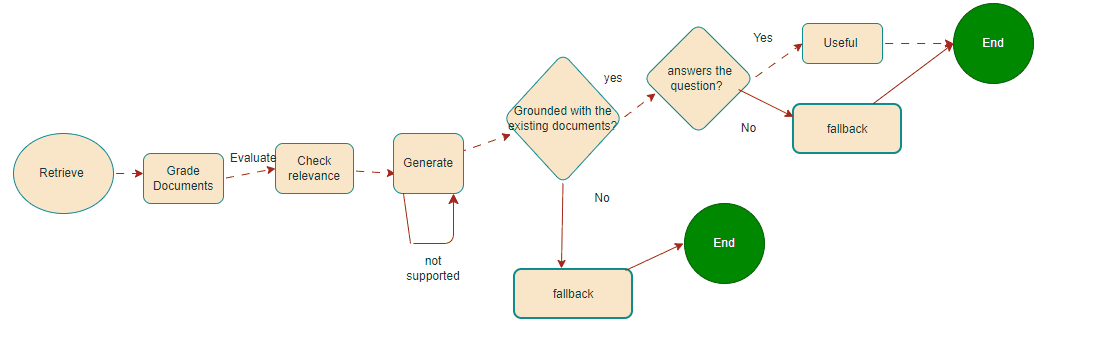

In [8]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core  faiss-cpu  pypdf langchain_community mdutils datasets langchain_huggingface xmltodict

In [9]:
import getpass
import os

# Load environment variables from a .env file
from google.colab import userdata
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"]="Medical Retreival for HealthCare"

In [10]:
from datasets import load_dataset

ds = load_dataset("gretelai/symptom_to_diagnosis")

In [11]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['output_text', 'input_text'],
        num_rows: 853
    })
    test: Dataset({
        features: ['output_text', 'input_text'],
        num_rows: 212
    })
})


In [12]:
from langchain_community.document_loaders import HuggingFaceDatasetLoader

In [13]:
dataset_name = "gretelai/symptom_to_diagnosis"
#ds = load_dataset("fhai50032/Symptoms_to_disease_7k")
#SathwikBalu/symptom_to_diagnosis

page_content_column = "input_text"


loader = HuggingFaceDatasetLoader(dataset_name, page_content_column)

In [14]:
data = loader.load()
data

[Document(metadata={'output_text': 'cervical spondylosis'}, page_content='"I\'ve been having a lot of pain in my neck and back. I\'ve also been having trouble with my balance and coordination. I\'ve been coughing a lot and my limbs feel weak."'),
 Document(metadata={'output_text': 'impetigo'}, page_content='"I have a rash on my face that is getting worse. It is red, inflamed, and has blisters that are bleeding clear pus. It is really painful."'),
 Document(metadata={'output_text': 'urinary tract infection'}, page_content='"I have been urinating blood. I sometimes feel sick to my stomach when I urinate. I often feel like I have a fever."'),
 Document(metadata={'output_text': 'arthritis'}, page_content='"I have been having trouble with my muscles and joints. My neck is really tight and my muscles feel weak. I have swollen joints and it is hard to move around without becoming stiff. It is also really uncomfortable to walk."'),
 Document(metadata={'output_text': 'dengue'}, page_content='"I

In [15]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
indexName="HF_SymptomsDiagnosis"

In [16]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(data)

In [17]:
from langchain_huggingface import HuggingFaceEmbeddings

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hfEmbeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
#vecStore=FAISS.from_documents(final_documents,hfEmbeddings)
#db =vecStore.save_local(folder_path="Database", index_name=indexName)

In [19]:
db=FAISS.load_local(folder_path="drive/MyDrive/Database", index_name=indexName, embeddings=hfEmbeddings,allow_dangerous_deserialization=True)

In [20]:
retriever = db.as_retriever()

In [21]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [22]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
#generation = rag_chain.invoke({"context": data, "question": question})
#print(generation)

In [23]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
#hallucination_grader.invoke({"documents": data, "generation": generation})

In [24]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
#answer_grader.invoke({"question": question, "generation": generation})

In [25]:
from langchain_community.tools.pubmed.tool import PubmedQueryRun
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.chat_models import ChatOpenAI
from langchain.agents.openai_tools.base import create_openai_tools_agent
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import AgentExecutor

### Question Goes to pubmed

# LLM
#llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

llm = ChatOpenAI(model="gpt-4o")
def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, Use the provided tools to progress towards answering the question."
                "You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    print(prompt)
    print(tools)
    agent = initialize_agent(
        tools, llm, agent=AgentType.CHAT_ZERO_SHOT_REACT_DESCRIPTION, verbose=True,
        agent_kwargs={"prompt": prompt},  # Pass the prompt template here
    )
    return agent

# Prompt
sys_message = """You are a helpful AI assistant who uses pubmed to ask the question and get the diagnosis for the symptoms in question."""
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(retriever,"MedicineRAG", "Search for information about Medical advancements. For any questions about Medicine, you must use this tool!")

tools = [
    #retriever_tool,
    Tool(
         name="PubmedQueryRun",
         func=PubmedQueryRun().run,
        description="Useful to get the causes and symptoms"
    )
    #,wiki
]

pubMedAgent = create_agent(
    llm,
    tools,
    system_message=sys_message,
)


input_variables=['messages'] input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.messages.function.Funct

<ipython-input-25-5c1762464a60>:13: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o")
<ipython-input-25-5c1762464a60>:30: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use :meth:`~Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc.` instead.
  agent = initialize_agent(


In [26]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [27]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print("START")
    question = state["question"]
    print(question)


    # Retrieval
    documents = retriever.invoke(question)
    print("documents")
    print(documents)

    return {"documents": documents, "question": question}

In [28]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


In [29]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


In [30]:
def fallback(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---Fallback to PUBMED QUERY---")
    question = state["question"]
    documents = state["documents"]

    #  question
    results = pubMedAgent.run(question)

    return {"documents": documents, "question":question, "generation":results}

In [31]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer or fallback mechanism be activated.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, GO TO FALLBACK OPTION---"
        )
        return "fallback"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [32]:
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        pprint("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [33]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("fallback", fallback)
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "fallback": "fallback",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "fallback",
    },
)
app = workflow.compile()

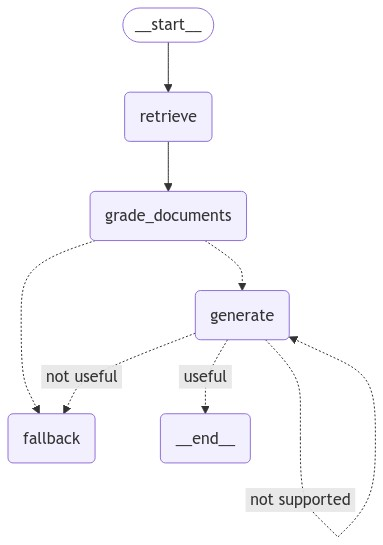

In [34]:

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something happened")
    pass

In [35]:
app

In [36]:
# Run
inputs = {
    "1": "I have heartburn and indigestion. I vomit everything I eat. Food gets stuck in my throat, making it difficult for me to swallow. I have a pain in my upper abdomen",
    "2": "I have been having migraines and headaches. I can't sleep. My whole body is shaking and shivering. I feel dizzy sometimes.",
    "3":"I have fever, chills and skin rashes" #pubmed
}

In [41]:
from pprint import pprint
inJson={}
for input in inputs:
    print(input)
    q = inputs[input]
    inJson ={ "question":q}
    for output in app.stream(inJson):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            pprint(value)
            # Optional: print full state at each node
            # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])

1
---RETRIEVE---
START
I have heartburn and indigestion. I vomit everything I eat. Food gets stuck in my throat, making it difficult for me to swallow. I have a pain in my upper abdomen
documents
[Document(metadata={'output_text': 'gastroesophageal reflux disease'}, page_content='"I have heartburn and indigestion. I often vomit whatever I eat and have difficulty swallowing food. I have a nagging pain in my upper abdomen. I have a hard time sleeping because of the pain."'), Document(metadata={'output_text': 'peptic ulcer disease'}, page_content='"I have a sour acidic taste in my mouth. I have frequent belching and burping. I have a feeling of pressure or fullness in my upper abdomen that last for a few hours. I have a pain in my upper abdomen that is worse when I eat."'), Document(metadata={'output_text': 'gastroesophageal reflux disease'}, page_content='"I have a burning sensation in my chest and throat. It feels like acid or food is coming up into my throat. It\'s worse when I lie dow